In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Dataset




In [49]:
import torch
import torch.nn as nn
import torchvision.models as models

class BottleneckAdapter(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        hidden = channels // reduction
        self.adapter = nn.Sequential(
            nn.Conv2d(channels, hidden, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden, channels, 1, bias=False)
        )

    def forward(self, x):
        return self.adapter(x)


class AdapterBlock(nn.Module):
    def __init__(self, block, channels, num_domains, reduction=16):
        super().__init__()
        self.block = block  # frozen backbone block

        # One bottleneck adapter per domain
        self.adapters = nn.ModuleList([
            BottleneckAdapter(channels, reduction) for _ in range(num_domains)
        ])

        self.bns = nn.ModuleList([
            nn.BatchNorm2d(channels) for _ in range(num_domains)
        ])

    def forward(self, x, domain_id):
        y = self.block(x)              
        y = self.bns[domain_id](y)
        y = y + self.adapters[domain_id](y)
        return y


class ResNet(nn.Module):
    def __init__(self, domains, num_classes_per_domain, reduction=16):
        super().__init__()
        base = models.resnet50(pretrained=True)

        for p in base.parameters():
            p.requires_grad = False

        self.domains = domains
        self.domain_to_id = {d: i for i, d in enumerate(domains)}

        self.stem = nn.Sequential(
            base.conv1, base.bn1, base.relu, base.maxpool
        )

        self.layer1 = base.layer1
        self.layer2 = base.layer2

        self.layer3 = nn.Sequential(*[
            AdapterBlock(block, 1024, len(domains), reduction) for block in base.layer3
        ])
        self.layer4 = nn.Sequential(*[
            AdapterBlock(block, 2048, len(domains), reduction) for block in base.layer4
        ])

        self.avgpool = base.avgpool
        self.classifiers = nn.ModuleList([
            nn.Linear(2048, num_classes_per_domain[d]) for d in domains
        ])

    def forward(self, x, domain_name):
        d = self.domain_to_id[domain_name]
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        for block in self.layer3:
            x = block(x, d)
        for block in self.layer4:
            x = block(x, d)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.classifiers[d](x)
    def extract_features(self, x, domain_name):
        d = self.domain_to_id[domain_name]
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        for block in self.layer3:
            x = block(x, d)
        for block in self.layer4:
            x = block(x, d)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)   # [B, 2048]
        return x



In [3]:
from itertools import islice
from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import DataLoader, IterableDataset
from sklearn.model_selection import train_test_split

import torchvision.transforms as transforms

train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])





In [4]:
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset

class HFDatasetWrapper(Dataset):
    def __init__(self, dataset, transform=None, label_key='label', label_to_idx=None):
        self.dataset = dataset
        self.transform = transform
        self.label_key = label_key
        self.label_to_idx = label_to_idx

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = np.array(item['image'])
        image = Image.fromarray(image)
    
        if self.transform:
            image = self.transform(image)
    
        label = item[self.label_key]
    
        if self.label_to_idx is not None:
            if isinstance(label, list):  
                label_tensor = torch.zeros(len(self.label_to_idx), dtype=torch.float32)
                for lbl in label:
                    label_tensor[self.label_to_idx[lbl]] = 1.0
            else:  
                label_tensor = torch.tensor(self.label_to_idx[label], dtype=torch.long)
        else:
            label_tensor = torch.tensor(label, dtype=torch.long)  
    
        return image, label_tensor



In [5]:
import os
num_cpus = os.cpu_count()


In [6]:
dataset_1 = load_dataset("blanchon/EuroSAT_RGB", split="train")

split_dataset_1 = dataset_1.train_test_split(test_size=0.6, seed=42)


euroSAT_train = split_dataset_1['train'] 
euroSAT_test = split_dataset_1['test']    

euroSAT_train = HFDatasetWrapper(euroSAT_train, transform=train_transform)
euroSAT_test = HFDatasetWrapper(euroSAT_test, transform=test_transform)

euroSAT_train_loader = DataLoader(euroSAT_train, batch_size=40, shuffle=True, num_workers = num_cpus // 2,persistent_workers=True,pin_memory=True)
euroSAT_test_loader = DataLoader(euroSAT_test, batch_size=40, shuffle=False,num_workers = num_cpus // 2,persistent_workers=True,pin_memory=True)




In [7]:
dataset_2 = load_dataset("blanchon/PatternNet", split="train")
split_dataset_2 = dataset_2.train_test_split(test_size=0.6, seed=42)

patternNet_train = split_dataset_2['train']
patternNet_test = split_dataset_2['test']

patternNet_train = HFDatasetWrapper(patternNet_train, transform=train_transform)
patternNet_test = HFDatasetWrapper(patternNet_test, transform=test_transform)

patternNet_train_loader = DataLoader(patternNet_train, batch_size=40, shuffle=True, num_workers = num_cpus // 2,persistent_workers=True,pin_memory=True)
patternNet_test_loader = DataLoader(patternNet_test, batch_size=40, shuffle=False, num_workers = num_cpus // 2,persistent_workers=True,pin_memory=True)


In [8]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

data_dir = "/home/23ucs712/MLRSNet-master/Images"



dataset = ImageFolder(root=data_dir, transform=test_transform)
print("Total samples:", len(dataset))
print("Classes:", len(dataset.classes))


Total samples: 111666
Classes: 46


In [9]:
train_size = int(0.6 * len(dataset))
test_size = len(dataset) - train_size


train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

MLRS_train_loader = DataLoader(train_dataset, batch_size=40,num_workers=num_cpus//2,shuffle=True)
MLRS_test_loader = DataLoader(test_dataset, batch_size=40,num_workers=num_cpus//2,shuffle=False)





In [10]:
# pip install librosa soundfile


In [11]:
domain_num_classes = {
    'EuroSAT': 10,
    'PatternNet': 38,
#    'RESISC45': 45,
    'MLRS': 46,
    'Advance': 13

    
}


In [12]:
dataset_5 = load_dataset("blanchon/ADVANCE", split='train')
split_dataset_5 = dataset_5.train_test_split(test_size=0.3, seed=42)

advance_train = split_dataset_5['train']
advance_test = split_dataset_5['test']

all_labels = set(example['label'] for example in advance_train)
sorted_labels = sorted(list(all_labels))
label_to_idx = {label: idx for idx, label in enumerate(sorted_labels)} 

wrapped_advance_train = HFDatasetWrapper(
    advance_train,
    transform=train_transform,
    label_key='label',
    label_to_idx=label_to_idx
)

wrapped_advance_test = HFDatasetWrapper(
    advance_test,
    transform=test_transform,
    label_key='label',
    label_to_idx=label_to_idx
)

from torch.utils.data import WeightedRandomSampler

labels = [label_to_idx[example['label']] for example in advance_train]
class_sample_counts = [labels.count(i) for i in range(len(sorted_labels))]
weights = [1.0 / class_sample_counts[label] for label in labels]

sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

advance_train_loader = DataLoader(
    wrapped_advance_train,
    batch_size=40,
    sampler=sampler,
    num_workers=num_cpus // 2,
    persistent_workers=True,
    pin_memory=True
)

advance_test_loader = DataLoader(
    wrapped_advance_test,
    batch_size=40,
    shuffle=False,
    num_workers=num_cpus // 2,
    persistent_workers=True,
    pin_memory=True
)





In [51]:
from torchvision.models import ResNet50_Weights

domain_list = ['EuroSAT', 'PatternNet', 'MLRS', 'Advance']

domain_num_classes = {
    'EuroSAT': 10,
    'PatternNet': 38,
    'MLRS': 46,
    'Advance': 13,   # or whatever it actually is
}

model = ResNet(
    domains=domain_list,
    num_classes_per_domain=domain_num_classes,
    reduction=32,    # or whatever you want
)


/home/23ucs712/miniconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/23ucs712/miniconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print("Trainable params:", trainable)
print("Total params:", total)



# for name, p in model.named_parameters():
#     if p.requires_grad:
#         print(name)


Trainable params: 5036139
Total params: 28544171


In [15]:
# train_loaders = {
#     'EuroSAT': euroSAT_train_loader,
#     'PatternNet': patternNet_train_loader,
# #    'RESISC45': RESISC_train,
#     'MLRS': MLRS_train_loader,
#     'Advance': advance_train_loader
# }

# test_loaders = {
#     'EuroSAT': euroSAT_test_loader,
#     'PatternNet': patternNet_test_loader,
# #    'RESISC45': RESISC_test,
#     'MLRS': MLRS_test_loader,
#     'Advance': advance_test_loader

# }


In [16]:
def evaluate(model, test_loaders, domain_num_classes):
    model.eval()
    
    with torch.no_grad():
        correct = 0
        total = 0
        print(f"\nEvaluating on domain: {domain}")
        progress_bar = tqdm(test_loaders[domain], desc=f"{domain} Eval", leave=False)

        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images, domain)

            # Optional safety check
            if outputs.shape[1] != domain_num_classes[domain]:
                print(f"[WARNING] Output dim {outputs.shape[1]} does not match expected {domain_num_classes[domain]} for {domain}")

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            progress_bar.set_postfix(acc=f"{100 * correct / total:.2f}%")

        accuracy = 100 * correct / total
        print(f"Final Accuracy on {domain}: {accuracy:.2f}%")
        



In [17]:
import torch
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(trainable_params, lr=1e-4, weight_decay=1e-4)


In [18]:
def train(model, dataloader, domain_name, optimizer, criterion, device, epochs=10):
    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images, domain_name)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = 100.0 * correct / total
        print(f"[{domain_name}] Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%")


In [19]:
def eval(model, dataloader, domain_name, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images, domain_name)
            preds = outputs.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = 100.0 * correct / total
    print(f"[{domain_name}] Eval Accuracy: {acc:.2f}%")
    return acc


In [20]:
def freeze_domain(model, current_domain):
    for name, param in model.named_parameters():
        if f".{current_domain}." in name and ("adapter" in name or "classifier" in name):
            param.requires_grad = True
        else:
            param.requires_grad = False


In [21]:
def domain_parameters(model,domain):
    return list(model.adapters[domain].parameters()) + list(model.classifiers[domain].parameters())


In [22]:
# from tqdm import tqdm
# import torch.nn as nn
# import torch.optim as optim
# from torch.optim.lr_scheduler import StepLR


# optimizer = {}
# scheduler = {}

# for domain in domain_list:
#     optimizer[domain] = optim.Adam(domain_parameters(model, domain), lr=1e-3)
#     scheduler[domain] = StepLR(optimizer[domain], step_size=15, gamma=0.1)
    
# num_epochs = 10


# for epoch in range(num_epochs):
#     model.train()
#     total_loss = 0.0
#     total_samples = 0

#     print(f"\nEpoch [{epoch+1}/{num_epochs}]")

#     for domain, loader in train_loaders.items():
#         criterion = nn.CrossEntropyLoss()
#         print(f"\nTraining on domain: {domain}")
#         domain_loss = 0.0
#         correct = 0
#         total = 0

#         progress_bar = tqdm(loader, desc=f"[{domain}]", leave=True)

#         freeze_domain(model, domain)

#         for images, labels in progress_bar:
#             images = images.to(device)
#             labels = labels.to(device)

#             optimizer[domain].zero_grad()
#             outputs = model(images, domain)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer[domain].step()

#             batch_size = images.size(0)
#             domain_loss += loss.item() * batch_size
#             total_loss += loss.item() * batch_size
#             total_samples += batch_size

#             _, predicted = torch.max(outputs, 1)
#             correct += (predicted == labels).sum().item()
#             total += labels.size(0)

#             progress_bar.set_postfix({
#                 'loss': f'{loss.item():.4f}',
#                 'acc': f'{100 * correct / total:.2f}%' 
#             })

#         avg_domain_loss = domain_loss / len(loader.dataset)
#         avg_domain_acc = 100 * correct / total
#         print(f"Domain: {domain}, Epoch Loss: {avg_domain_loss:.4f}, Accuracy: {avg_domain_acc:.2f}%")

#         scheduler[domain].step()

#         evaluate(model, test_loaders, domain_num_classes)

#     avg_total_loss = total_loss / total_samples
#     print(f"\nEpoch [{epoch+1}/{num_epochs}] Avg Total Loss: {avg_total_loss:.4f}")


# torch.save(model.state_dict(), "multimodal_final.pth")
# print("Final model saved as multimodal_final.pth")



In [39]:
train_loaders = {
    'EuroSAT': euroSAT_train_loader,
    'PatternNet': patternNet_train_loader,
    'MLRS': MLRS_train_loader,
    'Advance': advance_train_loader
}

test_loaders = {
    'EuroSAT': euroSAT_test_loader,
    'PatternNet': patternNet_test_loader,
    'MLRS': MLRS_test_loader,
    'Advance': advance_test_loader

}

domains = ['EuroSAT', 'PatternNet', 'MLRS', 'Advance']
model = ResNet(domains, domain_num_classes, reduction=32).to(device)

for d in domains:
    did = model.domain_to_id[d]

    for p in model.parameters():
        p.requires_grad = False

    for block in model.layer3:
        block.adapters[did].requires_grad_(True)
        block.bns[did].requires_grad_(True)

    for block in model.layer4:
        block.adapters[did].requires_grad_(True)
        block.bns[did].requires_grad_(True)

    for p in model.classifiers[did].parameters():
        p.requires_grad = True

    trainable_params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(
        trainable_params,
        lr=1e-3,          
        weight_decay=1e-4,
    )

    train(model, train_loaders[d], d, optimizer, criterion, device, epochs=10)
    eval(model, test_loaders[d], d, device)



===== Training LRA adapters for EuroSAT =====
[EuroSAT] Epoch 1/10 - Loss: 0.4131, Acc: 85.99%
[EuroSAT] Epoch 2/10 - Loss: 0.2075, Acc: 93.63%
[EuroSAT] Epoch 3/10 - Loss: 0.1554, Acc: 94.83%
[EuroSAT] Epoch 4/10 - Loss: 0.1467, Acc: 95.34%
[EuroSAT] Epoch 5/10 - Loss: 0.1116, Acc: 96.40%
[EuroSAT] Epoch 6/10 - Loss: 0.1039, Acc: 96.39%
[EuroSAT] Epoch 7/10 - Loss: 0.0805, Acc: 97.11%
[EuroSAT] Epoch 8/10 - Loss: 0.0849, Acc: 97.38%
[EuroSAT] Epoch 9/10 - Loss: 0.0767, Acc: 97.50%
[EuroSAT] Epoch 10/10 - Loss: 0.0614, Acc: 97.96%
[EuroSAT] Eval Accuracy: 96.83%

===== Training LRA adapters for PatternNet =====
[PatternNet] Epoch 1/10 - Loss: 0.2720, Acc: 92.58%
[PatternNet] Epoch 2/10 - Loss: 0.0990, Acc: 96.99%
[PatternNet] Epoch 3/10 - Loss: 0.0702, Acc: 97.94%
[PatternNet] Epoch 4/10 - Loss: 0.0357, Acc: 98.98%
[PatternNet] Epoch 5/10 - Loss: 0.0351, Acc: 98.87%
[PatternNet] Epoch 6/10 - Loss: 0.0291, Acc: 99.08%
[PatternNet] Epoch 7/10 - Loss: 0.0319, Acc: 98.96%
[PatternNet] Epo

In [40]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")


Total parameters: 28,544,171


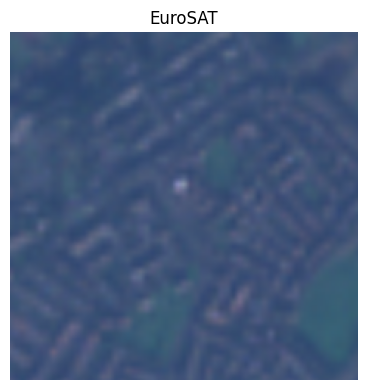

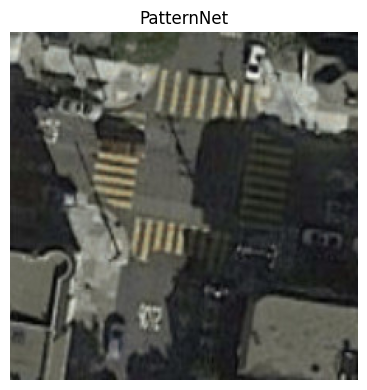

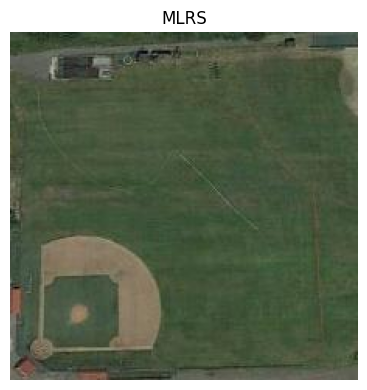

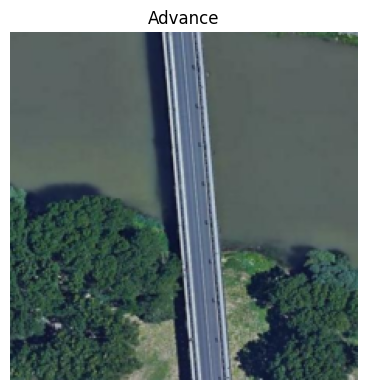

In [52]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# If you used ImageNet normalization in your transform:
imagenet_mean = torch.tensor([0.485, 0.456, 0.406])
imagenet_std  = torch.tensor([0.229, 0.224, 0.225])

def unnormalize(img):
    # img: [C, H, W] tensor
    img = img.clone()
    img = img * imagenet_std[:, None, None] + imagenet_mean[:, None, None]
    return torch.clamp(img, 0.0, 1.0)

# choose loaders (train or test)
loaders = {
    'EuroSAT': euroSAT_train_loader,
    'PatternNet': patternNet_train_loader,
    'MLRS': MLRS_train_loader,
    'Advance': advance_train_loader,
}

for name, loader in loaders.items():
    images, labels = next(iter(loader))     # one batch
    img = images[0].cpu()                   # first image [C,H,W]
    img = unnormalize(img)                  # back to [0,1] range
    img = img.permute(1, 2, 0).numpy()      # [H,W,C] for matplotlib

    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(name)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(f"{name}_sample.png", bbox_inches="tight", dpi=150)
    plt.show()


In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# loaders for tsne (usually test loaders)
loaders_for_tsne = {
    'EuroSAT': euroSAT_test_loader,
    'PatternNet': patternNet_test_loader,
    'MLRS': MLRS_test_loader,
    'Advance': advance_test_loader,
}

def collect_features(model, loaders, n_per_domain=300):
    all_feats = []
    all_domains = []

    with torch.no_grad():
        for domain_name, loader in loaders.items():
            collected = 0
            for images, labels in loader:
                images = images.to(device)
                feats = model.extract_features(images, domain_name)  # [B, 2048]
                all_feats.append(feats.cpu())
                all_domains.extend([domain_name] * feats.size(0))

                collected += feats.size(0)
                if collected >= n_per_domain:
                    break

    all_feats = torch.cat(all_feats, dim=0).numpy()   # [N, 2048]
    all_domains = np.array(all_domains)
    return all_feats, all_domains

features, domains = collect_features(model, loaders_for_tsne, n_per_domain=300)
print("Feature matrix shape:", features.shape)


Feature matrix shape: (1280, 2048)


/home/23ucs712/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


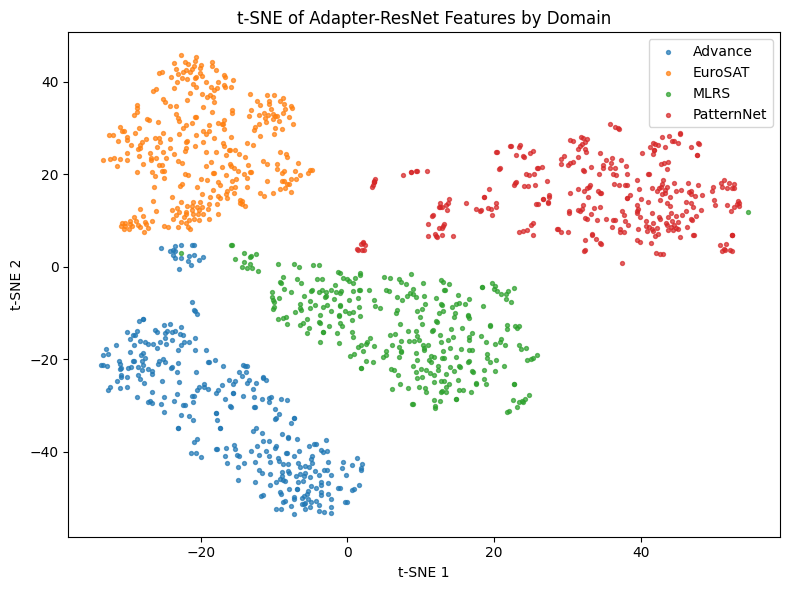

In [54]:
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    n_iter=1000,
    init="random",
    random_state=42,
)

features_2d = tsne.fit_transform(features)   # [N, 2]

plt.figure(figsize=(8, 6))
for domain_name in np.unique(domains):
    idx = domains == domain_name
    plt.scatter(
        features_2d[idx, 0],
        features_2d[idx, 1],
        s=8,
        alpha=0.7,
        label=domain_name,
    )

plt.legend()
plt.title("t-SNE of Adapter-ResNet Features by Domain")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()
